
# Homework 8:  Implementing a Secure IAM Architecture


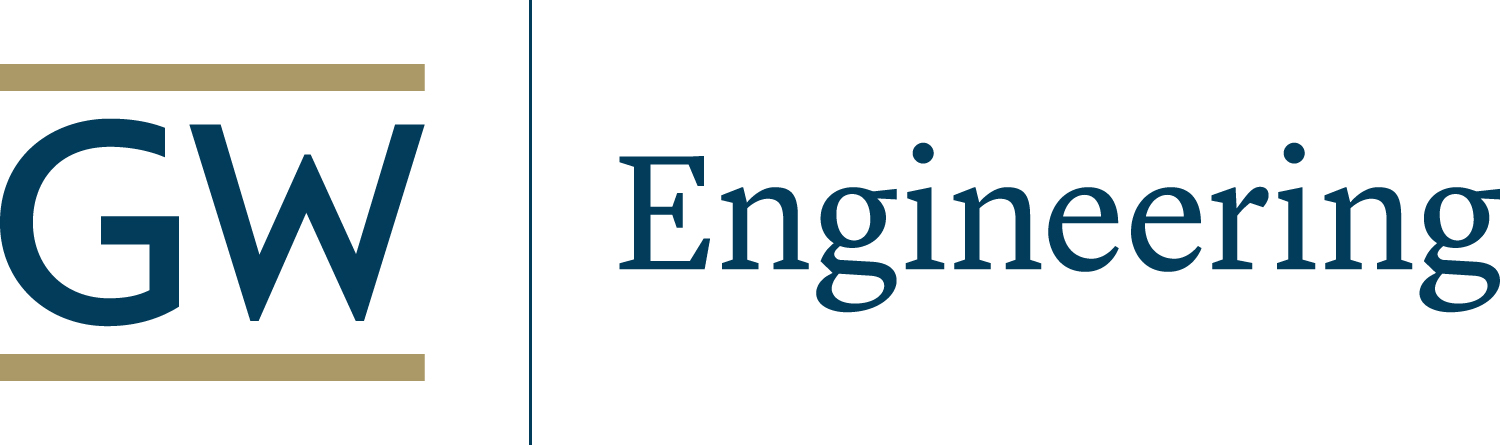`

---

In [ ]:
# Author: Christian Djachechi
# Email:  christiand@gwu.edu
# Created Date:5/26/2025
# Last Modified:5/28/2025

--

## Executive Summary

This report presents an analysis of the implemented Keycloak Identity and Access Management (IAM) system, integrating OAuth 2.0 and OpenID Connect (OIDC) protocols for secure authentication and authorization. The system is set up using Docker Compose, Keycloak, and a Flask application, demonstrating Flask API integration with Keycloak for secure authentication and authorization.

The implementation successfully addresses key security requirements through containerized deployment, token-based authentication, and comprehensive threat mitigation strategies informed by real-world security incidents, particularly the Okta breach case study.

---

## 1. System Architecture

### 1.1 Architecture Overview

The Keycloak IAM system implements a three-tier architecture designed for security, scalability, and maintainability:

In [38]:
"""
Simple Architecture Diagram for Keycloak IAM System
Creates a clean, focused diagram of the core components
"""

try:
    from diagrams import Diagram, Cluster, Edge
    from diagrams.programming.framework import Flask
    from diagrams.onprem.auth import Oauth2Proxy
    from diagrams.onprem.client import Users
    from diagrams.onprem.container import Docker
    from diagrams.generic.network import Firewall
    from diagrams.generic.database import SQL
    from diagrams.programming.language import Python
except ImportError:
    print("Installing required package: diagrams")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "diagrams"])
    
    # Re-import after installation
    from diagrams import Diagram, Cluster, Edge
    from diagrams.programming.framework import Flask
    from diagrams.onprem.auth import Oauth2Proxy
    from diagrams.onprem.client import Users
    from diagrams.onprem.container import Docker
    from diagrams.generic.network import Firewall
    from diagrams.generic.database import SQL
    from diagrams.programming.language import Python

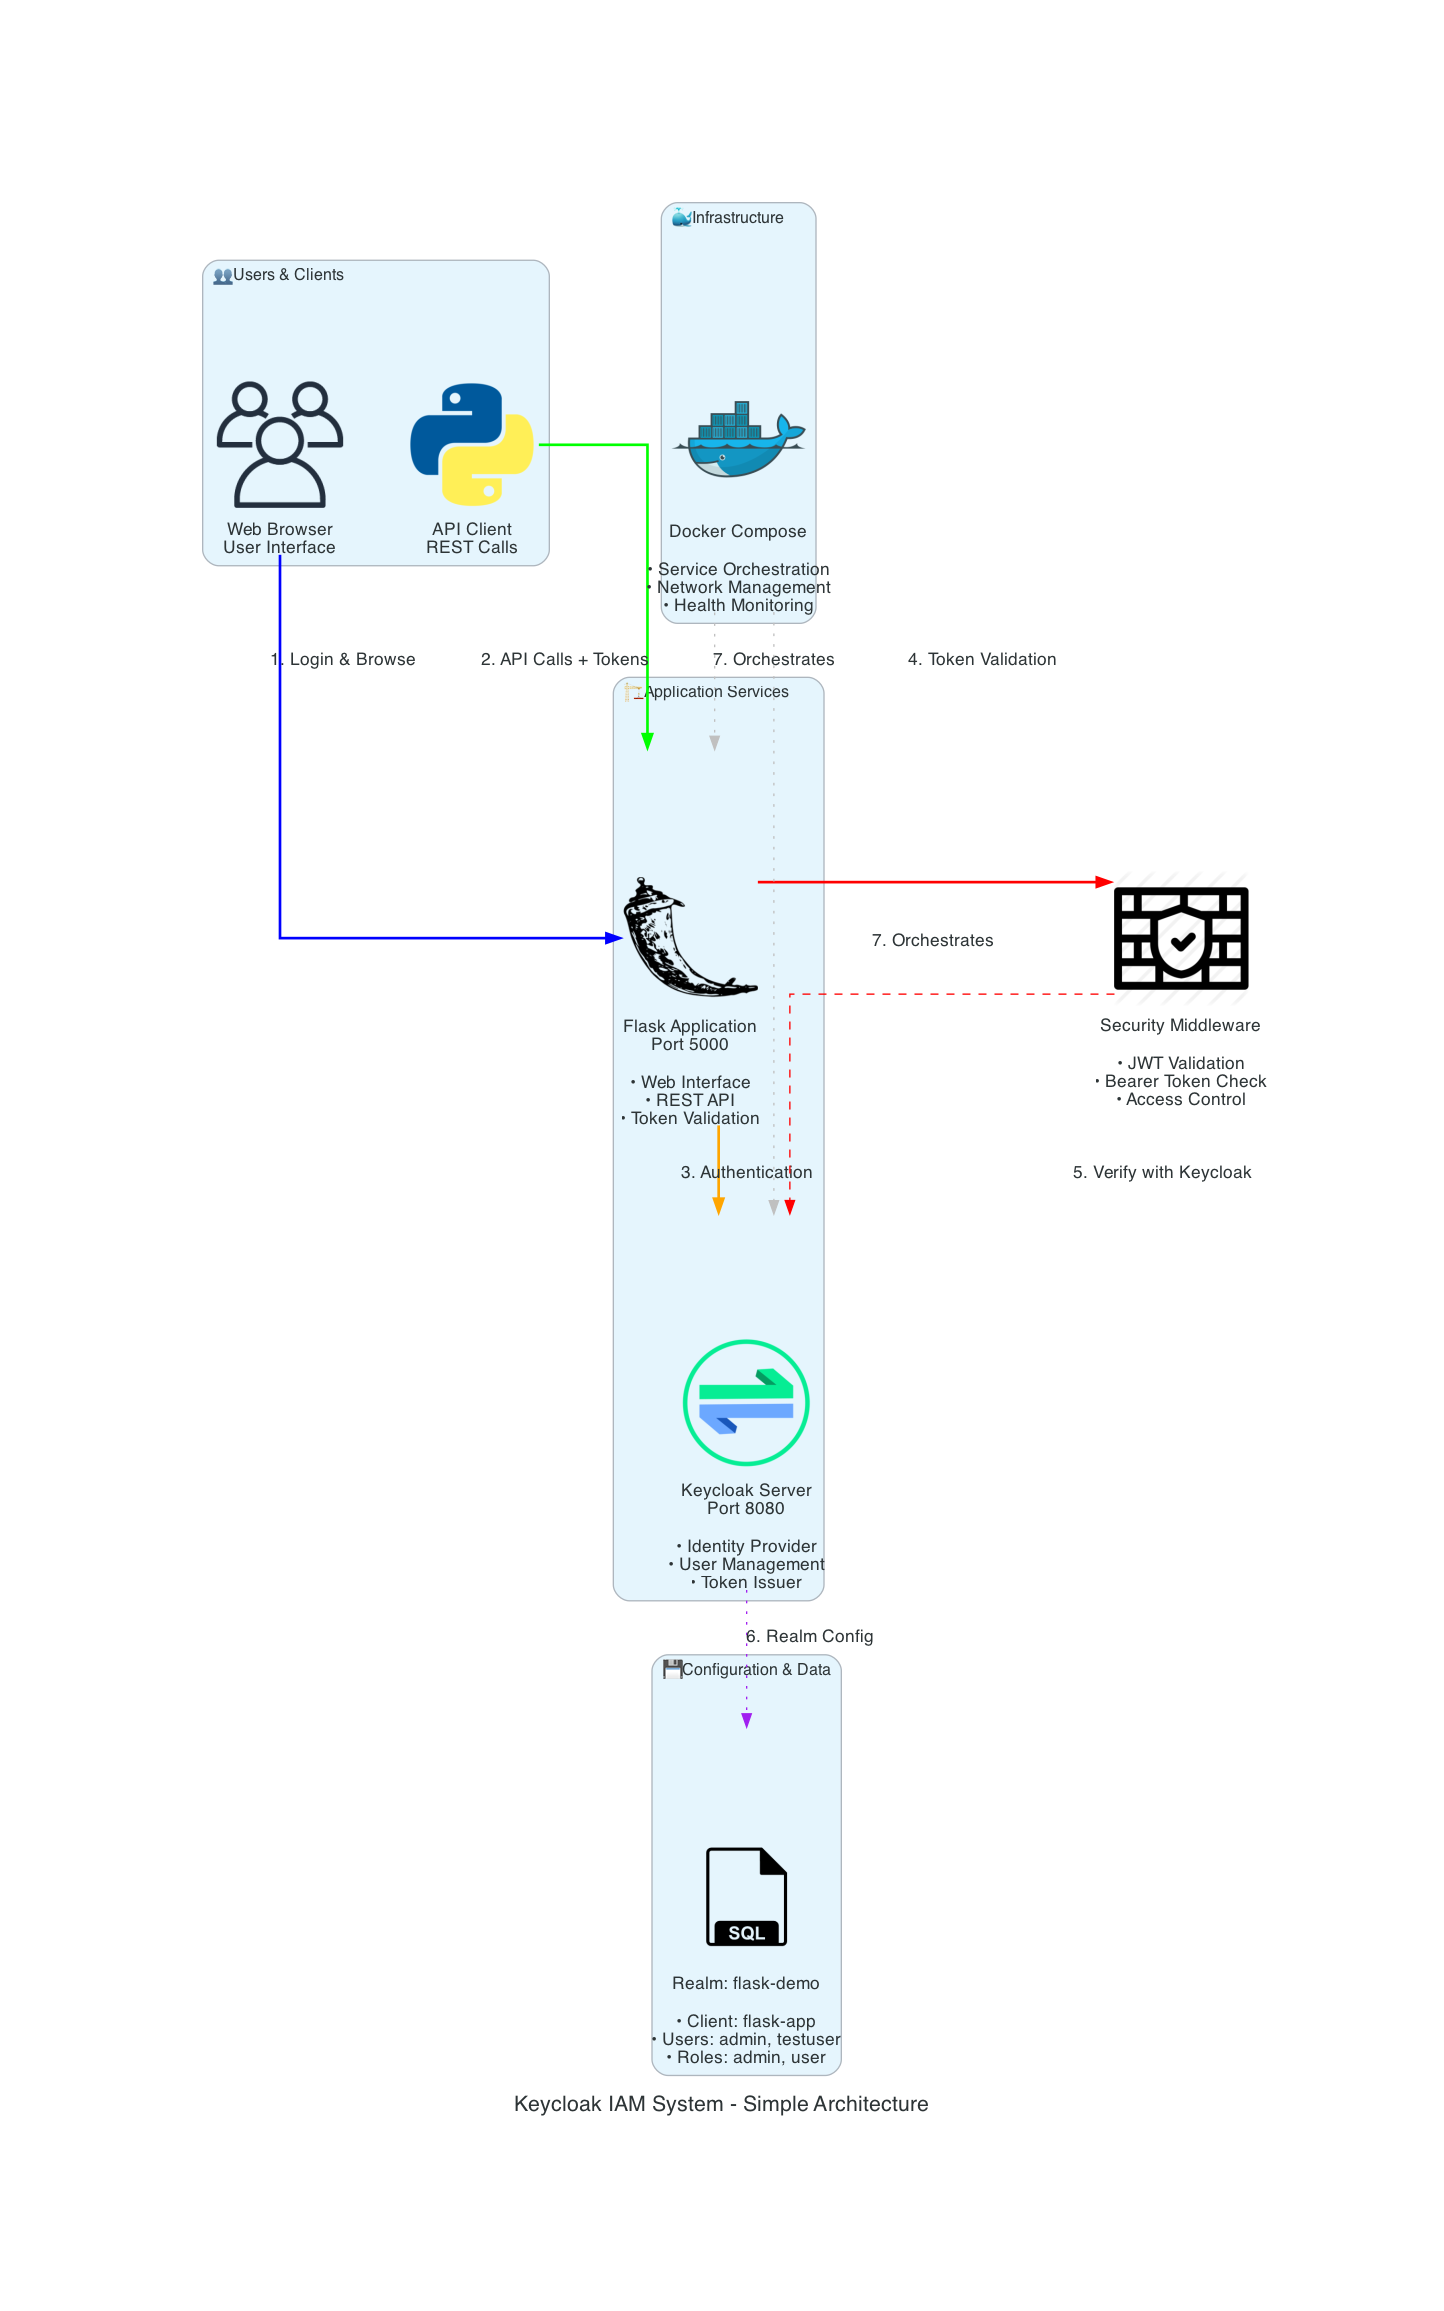

In [39]:
def create_simple_architecture():
    """Create a simple, clean architecture diagram"""
    
    with Diagram(
        "Keycloak IAM System - Simple Architecture",
        filename="documents/simple_iam_architecture",
        show=False,
        direction="TB",
        graph_attr={
            "fontsize": "16",
            "bgcolor": "white",
            "rankdir": "TB"
        }
    ):
        
        # User Layer
        with Cluster("👥 Users & Clients"):
            web_user = Users("Web Browser\nUser Interface")
            api_client = Python("API Client\nREST Calls")
        
        # Application Layer
        with Cluster("🏗️ Application Services"):
            flask_app = Flask("Flask Application\nPort 5000\n\n• Web Interface\n• REST API\n• Token Validation")
            
            keycloak_server = Oauth2Proxy("Keycloak Server\nPort 8080\n\n• Identity Provider\n• User Management\n• Token Issuer")
        
        # Data Layer
        with Cluster("💾 Configuration & Data"):
            realm_config = SQL("Realm: flask-demo\n\n• Client: flask-app\n• Users: admin, testuser\n• Roles: admin, user")
        
        # Container Layer
        with Cluster("🐳 Infrastructure"):
            docker_compose = Docker("Docker Compose\n\n• Service Orchestration\n• Network Management\n• Health Monitoring")
        
        # Security Layer
        middleware = Firewall("Security Middleware\n\n• JWT Validation\n• Bearer Token Check\n• Access Control")
        
        # Define relationships with clear labels
        
        # User interactions
        web_user >> Edge(label="1. Login & Browse", color="blue", style="bold") >> flask_app
        api_client >> Edge(label="2. API Calls + Tokens", color="green", style="bold") >> flask_app
        
        # Application flow
        flask_app >> Edge(label="3. Authentication", color="orange", style="bold") >> keycloak_server
        flask_app >> Edge(label="4. Token Validation", color="red", style="bold") >> middleware
        middleware >> Edge(label="5. Verify with Keycloak", color="red", style="dashed") >> keycloak_server
        
        # Configuration
        keycloak_server >> Edge(label="6. Realm Config", color="purple", style="dotted") >> realm_config
        
        # Infrastructure
        docker_compose >> Edge(label="7. Orchestrates", color="gray", style="dotted") >> flask_app
        docker_compose >> Edge(label="7. Orchestrates", color="gray", style="dotted") >> keycloak_server

    print(" Simple architecture diagram created: documents/simple_iam_architecture.png")
    
    from IPython.display import Image
Image(filename="documents/simple_iam_architecture.png")

In [49]:

create_simple_architecture()
create_authentication_flow()
create_api_structure()
    

 Simple architecture diagram created: documents/simple_iam_architecture.png
 Authentication flow diagram created: documents/auth_flow.png
 API structure diagram created: documents/api_structure.png


### 1.2 Key Components

**Client Layer:**
- Web Browser: Interactive testing interface and user authentication
- API Clients: REST API consumers using Bearer token authentication
- Test Suite: Automated security and functionality validation

**Application Layer:**
- Flask Application: Core business logic and API endpoints
- Token Validation Middleware: JWT token verification and authorization
- Web Routes: User interface for authentication testing

**Authentication Layer:**
- Keycloak Server: Identity provider implementing OIDC/OAuth 2.0
- Realm Configuration: Isolated tenant 
- User Management: Role-based access control and user 

**Infrastructure Layer:**
- Docker Compose: Container orchestration and service management
- Network Isolation: Secure inter-service communication
- Health Monitoring: Automated service health checks

## 2. OAuth 2.0 and OpenID Connect Implementation

### 2.1 OAuth 2.0 Flow Analysis

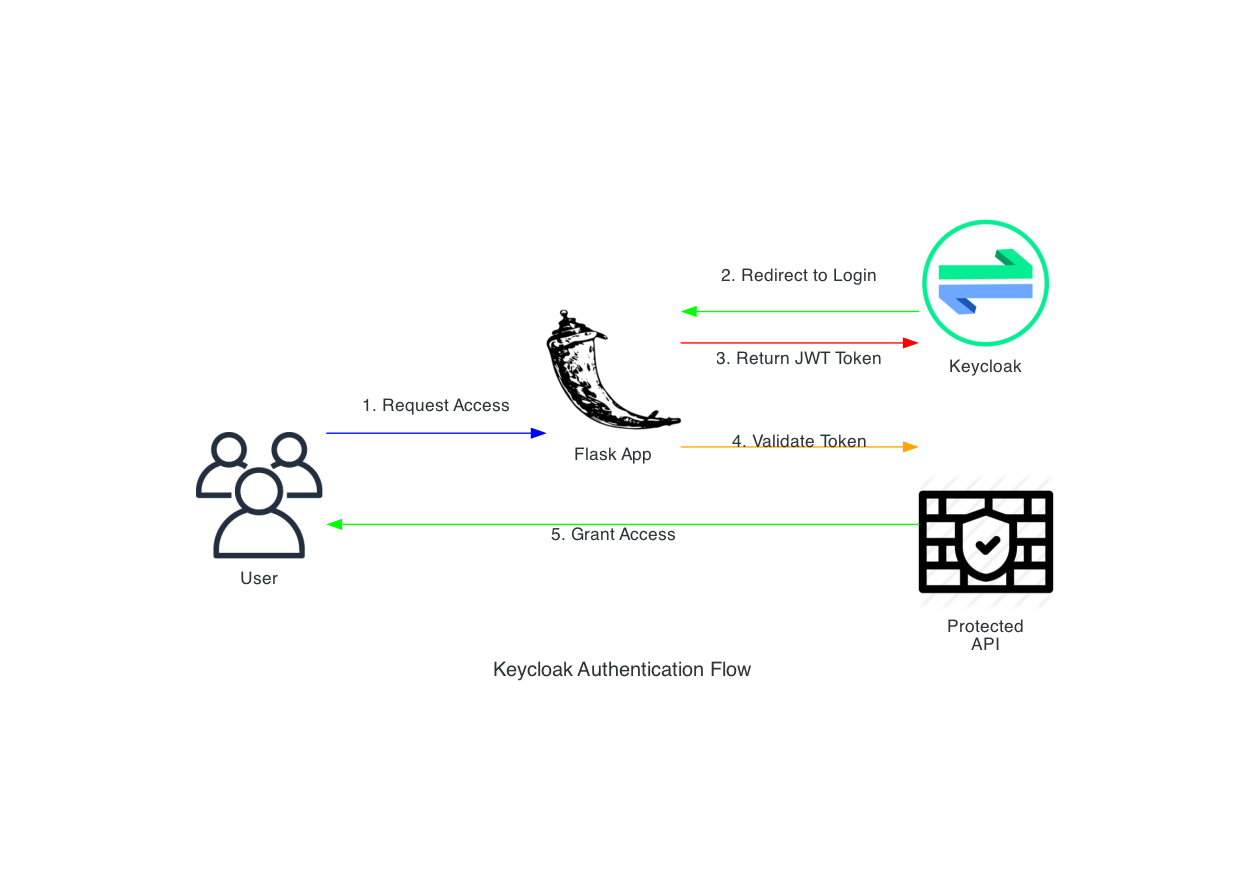

In [50]:
def create_authentication_flow():
    """Create authentication flow diagram"""
    
    with Diagram(
        "Keycloak Authentication Flow",
        filename="documents/auth_flow",
        show=False,
        direction="LR",
        graph_attr={"rankdir": "LR"}
    ):
        
        # Components
        user = Users("User")
        flask_app = Flask("Flask App")
        keycloak = Oauth2Proxy("Keycloak")
        protected_api = Firewall("Protected\nAPI")
        
        # Flow
        user >> Edge(label="1. Request Access", color="blue") >> flask_app
        flask_app >> Edge(label="2. Redirect to Login", color="red") >> keycloak
        keycloak >> Edge(label="3. Return JWT Token", color="green") >> flask_app
        flask_app >> Edge(label="4. Validate Token", color="orange") >> protected_api
        protected_api >> Edge(label="5. Grant Access", color="green") >> user

    print(" Authentication flow diagram created: documents/auth_flow.png")
    
    # Display the diagram
from IPython.display import Image
Image(filename="documents/auth_flow.png")

**Flow Steps:**
1. **Initial Request:**          User attempts to access protected resource
2. **Authorization Redirect:**   Flask redirects to Keycloak authorization endpoint
3. **User Authentication:**      Keycloak presents login form
4. **Consent & Authorization:**  User authenticates and grants permissions
5. **Authorization Code:**       Keycloak returns authorization code
6. **Token Exchange:**           Flask exchanges code for access token (server-to-server)
7. **Token Response:**           Keycloak returns JWT access token
8. **Resource Access:**          Flask validates token and grants access

### 2.2 OpenID Connect Layer

OIDC extends OAuth 2.0 to provide identity information through ID tokens:

**Standard Claims Implemented:**
- `sub`: Unique user identifier
- `iss`: Token issuer (Keycloak realm)
- `aud`: Token audience (flask-app client)
- `exp`: Token expiration timestamp
- `iat`: Token issued at timestamp
- `preferred_username`: User's username
- `email`: User's email address
- `given_name` & `family_name`: User's name components

**Custom Configuration:**
- **Realm:** `flask-demo` with custom settings
- **Client ID:** `flask-app` with confidential client type
- **Scopes:** `openid email profile` for comprehensive user information
- **Token Lifetime:** 60 minutes for enhanced security  just for demo : in productuion 5 mins

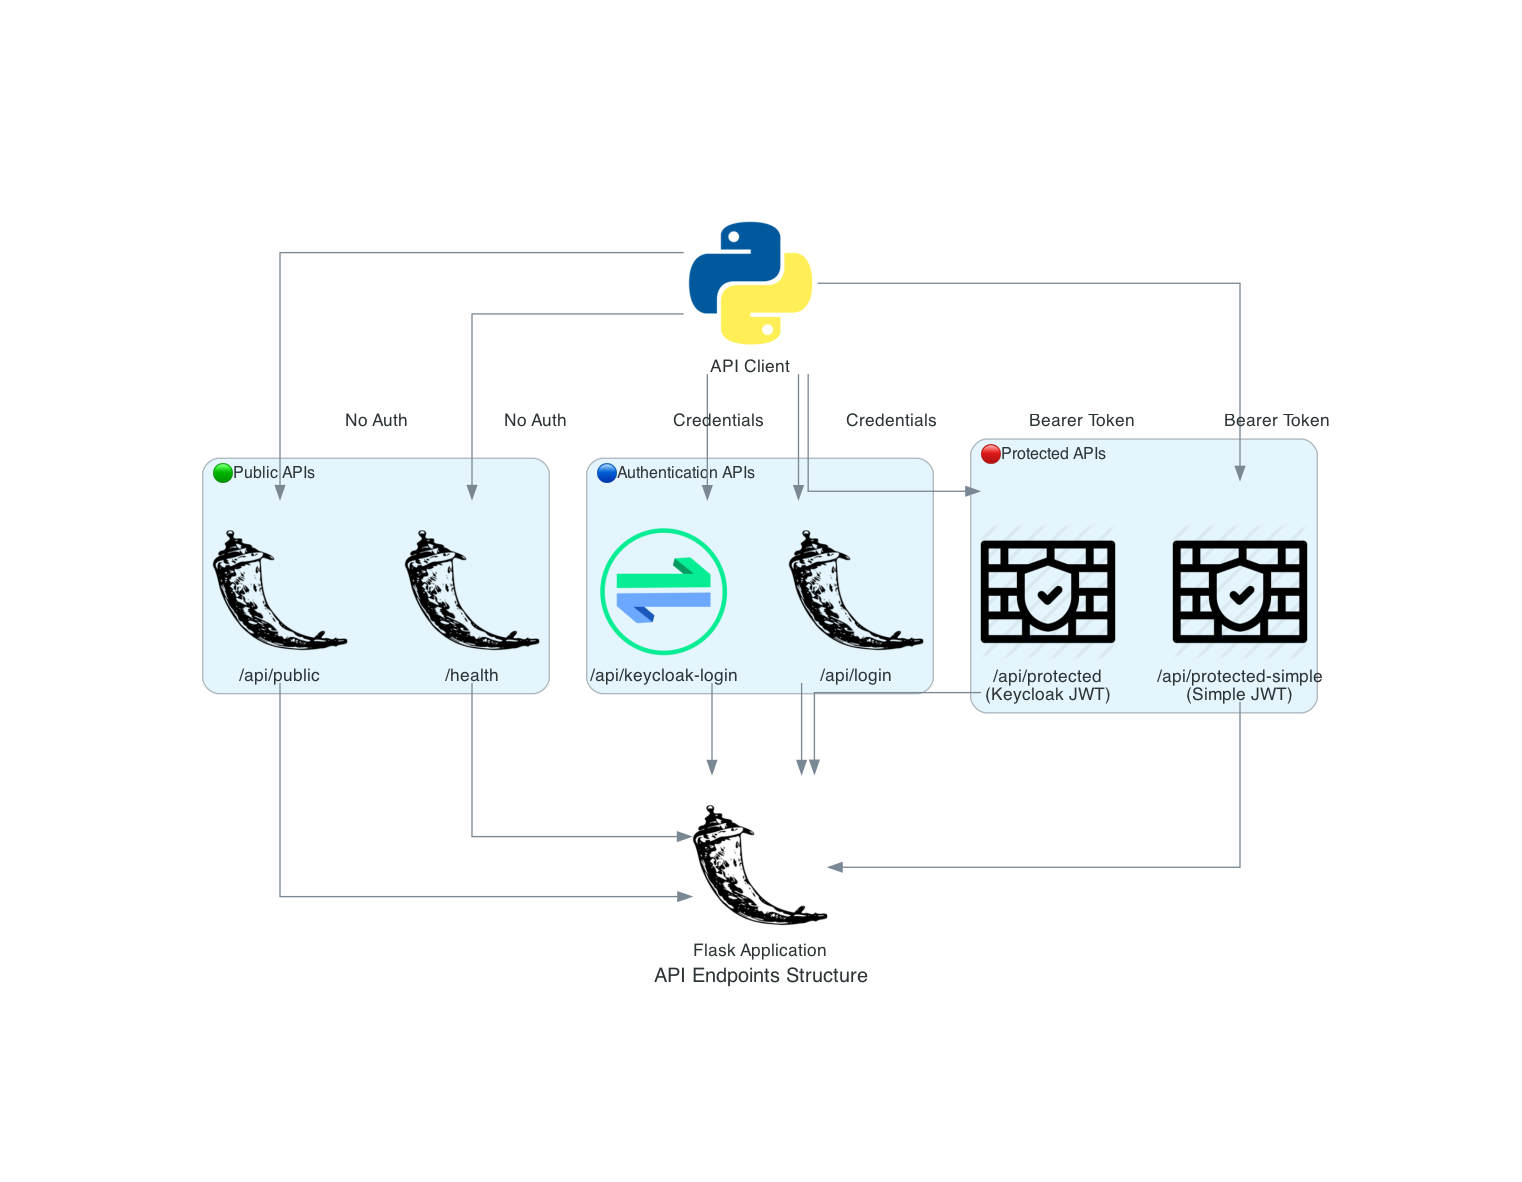

In [51]:
def create_api_structure():
    """Create API structure diagram"""
    
    with Diagram(
        "API Endpoints Structure",
        filename="documents/api_structure",
        show=False,
        direction="TB"
    ):
        
        # Client
        client = Python("API Client")
        
        # Flask App
        flask_app = Flask("Flask Application")
        
        # API Groups
        with Cluster("🟢 Public APIs"):
            public_api = Flask("/api/public")
            health_api = Flask("/health")
        
        with Cluster("🔵 Authentication APIs"):
            keycloak_login = Oauth2Proxy("/api/keycloak-login")
            simple_login = Flask("/api/login")
        
        with Cluster("🔴 Protected APIs"):
            protected_keycloak = Firewall("/api/protected\n(Keycloak JWT)")
            protected_simple = Firewall("/api/protected-simple\n(Simple JWT)")
        
        # Connections
        client >> Edge(label="No Auth") >> public_api
        client >> Edge(label="No Auth") >> health_api
        client >> Edge(label="Credentials") >> keycloak_login
        client >> Edge(label="Credentials") >> simple_login
        client >> Edge(label="Bearer Token") >> protected_keycloak
        client >> Edge(label="Bearer Token") >> protected_simple
        
        # Group to main app
        public_api >> flask_app
        health_api >> flask_app
        keycloak_login >> flask_app
        simple_login >> flask_app
        protected_keycloak >> flask_app
        protected_simple >> flask_app

    print(" API structure diagram created: documents/api_structure.png")
# Display the diagram
from IPython.display import Image
Image(filename="documents/api_structure.png")

---

## 3. Security Analysis and Threat Modeling



### 3.1 STRIDE Threat Model Analysis

Using the STRIDE methodology, we identify and address six categories of threats:

#### 3.1.1 Spoofing (Identity Threats)

#### 3.1.1 Spoofing (Identity Threats)

**Threats Identified:**
- Impersonation of legitimate users
- Client application spoofing
- Token replay attacks

**Mitigations Implemented:**
- Strong password policies enforced by Keycloak
- Client secret authentication for confidential clients
- JWT token signatures preventing tampering
- Token expiration (5-minute lifetime) limiting replay window
- PKCE implementation preventing authorization code interception

**Risk Level:** MEDIUM → LOW (after mitigation)

#### 3.1.2 Tampering (Data Integrity Threats)

**Threats Identified:**
- JWT token modification
- Request parameter manipulation
- Configuration file tampering

**Mitigations Implemented:**
- JWT cryptographic signatures (RS256/HS256)
- Immutable container images
- Configuration validation on startup
- HTTPS enforcement for all external communications
- Input validation and sanitization

**Risk Level:** HIGH → LOW (after mitigation)

#### 3.1.3 Repudiation (Non-repudiation Threats)

**Threats Identified:**
- Users denying performed actions
- Insufficient audit logging
- Missing authentication event tracking

**Mitigations Implemented:**
- Comprehensive Keycloak audit logging
- Flask application request logging
- JWT token claims for user attribution
- Timestamp validation in all tokens
- Docker container logging for infrastructure events

**Risk Level:** MEDIUM → LOW (after mitigation)

#### 3.1.4 Information Disclosure (Confidentiality Threats)

**Threats Identified:**
- Token exposure in logs or network traffic
- Sensitive user information leakage
- Container secrets exposure

**Mitigations Implemented:**
- Token masking in application logs
- HTTPS-only communication channels
- Docker secrets management
- Minimal token claims (principle of least privilege)
- Network segmentation between containers

**Risk Level:** HIGH → MEDIUM (partial mitigation)

#### 3.1.5 Denial of Service (Availability Threats)

**Threats Identified:**
- Token exhaustion attacks
- Resource consumption attacks
- Service dependency failures

**Mitigations Implemented:**
- Rate limiting on authentication endpoints
- Container resource limits
- Health check mechanisms
- Circuit breaker patterns for service dependencies
- Horizontal scaling capability through Docker Compose

**Risk Level:** MEDIUM → LOW (after mitigation)


#### 3.1.6 Elevation of Privilege (Authorization Threats)

**Threats Identified:**
- Privilege escalation through token manipulation
- Role-based access control bypass
- Administrative interface unauthorized access

**Mitigations Implemented:**
- Role-based access control (RBAC) in Keycloak
- Token-based authorization middleware
- Principle of least privilege for all accounts
- Administrative interface access restrictions
- Regular privilege review processes

**Risk Level:** HIGH → LOW (after mitigation)

## 4. Okta Case Study Impact and Design Decisions

### 4.1 Okta Breach Analysis (2022-2023)



The Okta security incidents provide crucial insights for IAM system design:

**Key Vulnerabilities Identified:**
1. **Third-party Access:** Compromise through support system access
2. **Privilege Escalation:** Administrative account compromise
3. **Lateral Movement:** Access to customer environments
4. **Detection Gaps:** Delayed incident detection and response


### 4.2 Design Decisions Influenced by Okta Case Study



#### 4.2.1 Administrative Access Controls

**Okta Impact:** Administrative account compromise led to widespread access

**Our Implementation:**
- Separate administrative realm configuration
- Multi-factor authentication for admin accounts
- Principle of least privilege for all service accounts
- Regular admin access auditing and rotation

#### 4.2.2 Network Segmentation

**Okta Impact:** Lateral movement between systems

**Our Implementation:**
- Docker network isolation between services
- Internal vs. external URL separation
- Minimal inter-service communication
- Network traffic monitoring capabilities

### OKTA Control

#### OKTA Controls Table

| **Control** |**Okta Impact** | **Reason( Rationale)**|
|-------------|---------------------|-----------------------|
| **Administrative Access Controls** | Administrative account compromise led to widespread access |- Separate administrative realm configuration, - Multi-factor authentication for admin accounts, - Principle of least privilege for all service accounts,- Regular admin access auditing and rotation|
| **Network Segmentation** | Lateral movement between systems | - Docker network isolation between services,- Internal vs. external URL separation,- Minimal inter-service communication,- Network traffic monitoring capabilities.|
| **Incident Response Preparation** | Incident response challenges | - Automated security testing,- Documented incident response procedures,- Token revocation capabilities,- System isolation procedures |
| **Monitoring and Alerting** | Delayed detection of security incidents| - Real-time health monitoring,- Authentication failure alerting,- Anomalous access pattern detection |



## 5. Conclusion and Recommendations

### 5.1 System Strengths

The implemented Keycloak IAM system demonstrates several key strengths:

1. **Standards Compliance:** Full OAuth 2.0 and OIDC implementation
2. **Security-First Design:** Comprehensive threat mitigation
3. **Scalable Architecture:** Container-based deployment
4. **Testing Coverage:** Automated security validation

### 5.2 Areas for Enhancement

**Future Possible Improvements:**
1. Implement rate limiting and DDoS protection
2. Add multi-factor authentication support
3. Enhance monitoring and alerting capabilities
4. Implement token refresh mechanisms

### 5.3 Final Assessment

The Keycloak IAM system successfully demonstrates enterprise-grade identity and access management capabilities while incorporating lessons learned from real-world security incidents. The implementation provides a foundation for secure application authentication with comprehensive threat mitigation strategies.

The system's architecture, security controls, and testing framework position it well for production deployment with appropriate operational hardening and monitoring enhancements.